In [1]:
### Install the conda environment by running 
#conda env create --file ohknow-short-kmers.env
###the env file sits in the data directory
###then activate the environment and fire up jupyter lab by running
#conda activate ohknow-short-kmers
#jupyter lab

This notebook demonstrates how short k-mers can be used to quantify similarity between samples from targeted amplicon sequencing data. 

We compute pairwise k-mer distances beween 186 mosquito samples of different species. The kmer distances turn out to be a good proxy for taxonomy. 

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import itertools
import sys
import seaborn
from matplotlib.patches import Rectangle
import matplotlib.patches as mpatches

import os, io, random
import string

### Import data

There are two data files: one containing sample metadata and one containing the target haplotypes generated from the amplicon sequencing data.

In [3]:
#import files
haplotypes = pd.read_csv("../data/amplicon_haplotypes.csv")
meta = pd.read_csv("../data/amplicon_metadata.tsv", index_col=0, sep='\t')
samples = meta.index.values

The haplotype file contains for each sample and for each amplicon target one row per unique haplotype - so if the sample is heterozygous at a given target, there will be two rows with different haplotypes for the same sample-target combination. 

The haplotypes are short -- 160bp on average. There are 62 targets in total. For more information on the amplicon panel, called ANOSPP, see Makunin et al. Mol. Ecol. Resour. 2022.

In [4]:
haplotypes.head()

s_Sample  target                                          consensus
0  Abro-21      13  CATTTCTATCTGATGAAACTTGTGCCCGTGGTTTAATTAATGCGTA...
1  Abro-21      17  GGTCTAGACCCGGAAGCCCTCACCGGCAAATACCCGGTAAGTGTTT...
2  Abro-21      18  AAAAAGGATGAGGTGAGTACCAGACTCCTCCCAGAATGATTATAAT...
3  Abro-21      19  TATTTGTCCACCTTTTGCCGACCGAGTTTTCTTGCCCGAGACGCGT...
4  Abro-21      24  AATGTAGCCCCGAGCGCGAAGCCGTGAAGCTTCTGCGCGCCACCTC...

The sample file contains information about the species labels of the samples. Here we will focuss on the so-called species-groups, note that this term is not related to the same term which is sometimes used in fly taxonomy. For more information on how these species groups are formed, see Boddé et al. eLIFE 2022.

In [6]:
meta.head()

targets_amplified            type                 source  \
s_Sample                                                             
Adem-32                  28  amplicon_panel  Makunin et al. (2022)   
Abro-33                  38  amplicon_panel  Makunin et al. (2022)   
Ahan-615                 53  amplicon_panel  Makunin et al. (2022)   
Ahan-6-1                 59  amplicon_panel  Makunin et al. (2022)   
Abro-22                  62  amplicon_panel  Makunin et al. (2022)   

         abbreviation         consensus_label                      fine_sgp  \
s_Sample                                                                      
Adem-32           mrs  Anopheles_demeilloni_c  Anopheles_marshallii_complex   
Abro-33           mrs    Anopheles_brohieri_c  Anopheles_marshallii_complex   
Ahan-615          mrs    Anopheles_hancocki_c  Anopheles_marshallii_complex   
Ahan-6-1          mrs    Anopheles_hancocki_c  Anopheles_marshallii_complex   
Abro-22           mrs    Anopheles_brohieri_c  Anopheles_marshallii_complex   

                    intermediate_sgp                 coarse_sgp  \
s_Sample                                                          
Adem-32   Anopheles_marshallii_group  Myzomyia_Neocellia_series   
Abro-33   Anopheles_marshallii_group  Myzomyia_Neocellia_series   
Ahan-615  Anopheles_marshallii_group  Myzomyia_Neocellia_series   
Ahan-6-1  Anopheles_marshallii_group  Myzomyia_Neocellia_series   
Abro-22   Anopheles_marshallii_group  Myzomyia_Neocellia_series   

                 partner_label BOLD_best_match COI_best_match  \
s_Sample                                                        
Adem-32   Anopheles_demeilloni        No_match  Anopheles_sp.   
Abro-33     Anopheles_brohieri        No_match  Anopheles_sp.   
Ahan-615    Anopheles_hancocki        No_match  Anopheles_sp.   
Ahan-6-1    Anopheles_hancocki        No_match  Anopheles_sp.   
Abro-22     Anopheles_brohieri        No_match  Anopheles_sp.   

         COI_second_match ITS2_best_match   ITS2_second_match  \
s_Sample                                                        
Adem-32     Anopheles_sp.   Anopheles_sp.  Anopheles_theileri   
Abro-33     Anopheles_sp.   Anopheles_sp.  Anopheles_theileri   
Ahan-615    Anopheles_sp.   Anopheles_sp.  Anopheles_theileri   
Ahan-6-1    Anopheles_sp.   Anopheles_sp.  Anopheles_theileri   
Abro-22     Anopheles_sp.   Anopheles_sp.  Anopheles_theileri   

         barcode_match_level sgp_match_level potential_conflict  \
s_Sample                                                          
Adem-32             close_sp            fine                NaN   
Abro-33             close_sp            fine                NaN   
Ahan-615            close_sp            fine                NaN   
Ahan-6-1            close_sp            fine                NaN   
Abro-22             close_sp            fine                NaN   

          single_representative  
s_Sample                         
Adem-32                   False  
Abro-33                   False  
Ahan-615                  False  
Ahan-6-1                  False  
Abro-22                   False

### Functions

In [8]:
def compute_sample_distance_per_target(samp1, samp2, hap, target, refkmers):
    '''
    This function computes the k-mer distance between two samples at a given target
    It does so by averaging the distance over all pairs of haplotypes between the two samples
    It returns a single value, which is the normalised kmer distance at this target
    samp1, samp2: sample IDs of the samples you want to compare
    hap: dataframe containing haplotypes, with the combUID column included
    target: the target for which you want to compute k-mer distance 
    refkmers: the matrix with the k-mer count tables of unique haplotypes
    '''
    #collect IDs of unique 
    s1 = hap.loc[(hap.s_Sample == samp1) & (hap.target==target), 'combUID'].unique()
    s2 = hap.loc[(hap.s_Sample == samp2) & (hap.target==target), 'combUID'].unique()
    assert len(s1)>0 and len(s2)>0, f"target {target} is not amplified in both samples {samp1} and {samp2}"
    dist = 0
    #for each pair of haplotypes between samples
    for sq1 in s1:
        for sq2 in s2:
            c1 = int(sq1.split('-')[1])
            c2 = int(sq2.split('-')[1])
            #compute the kmer distance and add to d
            d = np.sum(np.abs(refkmers[target,c1,:] - refkmers[target,c2,:]))/np.sum(refkmers[target,c1,:] + refkmers[target,c2,:])
            dist += d
    dist = dist/(len(s1)*len(s2))
    return(dist)

In [20]:
def construct_distance_array(haplotypes, refkmers, samples):
    '''
    This function computes the distances between all samples at the targets where both of them are amplified
    It returns an array of shape 62 x len(samples) x len(samples)
    That is one matrix with all sample-sample comparisions per target
    haplotypes: dataframe containing haplotypes, with the combUID column included
    refkmers: the matrix with the k-mer count tables of unique haplotypes
    samples: the list of all sample IDs in a particular order
    '''
    
    #initialise distance array
    distances = np.empty((62, len(samples), len(samples)))
    distances[:] = np.nan
    
    #compute distances per target
    for t in np.arange(62):
        samp_t = samples[np.isin(samples, haplotypes.loc[haplotypes.target==t, 's_Sample'])]
        
        #iterate through sample pairs
        for e, samp1 in enumerate(samples[:-1]):
            #check that sample has amplified at this target
            if np.isin(samp1, samp_t):
                for ee, samp2 in enumerate(samples[e+1:]):
                    if np.isin(samp2, samp_t):
                        distances[t,e,e+1+ee] = compute_sample_distance_per_target(samp1, samp2, haplotypes, t, refkmers)
                        distances[t,e+1+ee,e] = distances[t,e,e+1+ee]
        #deal with the last sample (which will never be the first of a pair)
        if np.isin(samples[-1], samp_t):
            dists = distances[t,-1,:]
        print("amplicon ", t, " done")
    return(distances)
            
    

In [10]:
def construct_kmer_dict(k):
    '''
    This function constructs a dictonary mapping all possible k-mers of length k to a unique integer in the range [0,4^k)
    '''
    labels = []
    for i in itertools.product('ACGT', repeat=k):
        labels.append(''.join(i))
    kmerdict = dict(zip(labels, np.arange(4**k)))
    return(kmerdict)

In [17]:
def haplotype_kmer_table(k, seq, max_uh):
    '''
    This fuction translates every unique haplotype into a k-mer count table
    I.e. for each unique k-mer of length k, it counts how often this k-mer occurs in the haplotype under consideration
    Note that for k>4 this table is quite sparse (because haplotypes are 160bp on average and there are 256 possible 4-mers, 1024 possible 5-mers, etc.)
    It returns a table of shape 62 x max_uh x 4^k, containing k-mer counts for each unique haplotype
    k: kmer length
    seq: a dataframe containing unique haplotypes with their combUID
    max_uh: the maximum number of unique haplotypes per target
    '''
    #construct k-mer dict
    kmerdict = construct_kmer_dict(k)
    table = np.zeros((62, max_uh, 4**k), dtype='int')
    #go through all unique haplotypes
    for r in seq.index:
        combid = str.split(seq.loc[r,'combUID'], '-')
        t, u = int(combid[0]), int(combid[1])
        sq = seq.loc[r,'consensus']
        #generate k-mer counts
        for i in np.arange(len(sq)-(k-1)):
            table[t,u,kmerdict[sq[i:i+k]]] += 1
    return(table)

In [15]:
def assign_combUID(haplotypes): 
    '''
    This function assigns IDs to unique haplotypes
    The idea is of the form 't-u', where t is the target corresponding to the haplotype and u the identifier
    Returns dataframe containing the haplotypes with an additional column containing the combUID
    '''
    combuids = dict()
    for tgt, group in haplotypes.groupby('target'):
        for (i, cons) in enumerate(group['consensus'].unique()):
            combuids[str(tgt)+cons] = '{}-{}'.format(tgt, i)
    haplotypes['combUID'] = (haplotypes.target.astype('str') + haplotypes.consensus).replace(combuids)
    return(haplotypes)

### Process data

In [16]:
#append unique identifier column to the haplotypes dataframe
haplotypes = assign_combUID(haplotypes)

In [18]:
#Make an array with k-mer counts of unique haplotypes
#Here you can adjust the value of k and check its effects.
maxallele = haplotypes.groupby('target')['combUID'].nunique().max()
combUIDunique = haplotypes[['combUID', 'consensus']].drop_duplicates()
refkmers = haplotype_kmer_table(k=8, seq=combUIDunique, max_uh=maxallele)

In [21]:
#compute pairwise distances betweens samples
sample_distances = construct_distance_array(haplotypes=haplotypes, refkmers=refkmers, samples=samples)

amplicon  0  done
amplicon  1  done
amplicon  2  done
amplicon  3  done
amplicon  4  done
amplicon  5  done
amplicon  6  done
amplicon  7  done
amplicon  8  done
amplicon  9  done
amplicon  10  done
amplicon  11  done
amplicon  12  done
amplicon  13  done
amplicon  14  done
amplicon  15  done
amplicon  16  done
amplicon  17  done
amplicon  18  done
amplicon  19  done
amplicon  20  done
amplicon  21  done
amplicon  22  done
amplicon  23  done
amplicon  24  done
amplicon  25  done
amplicon  26  done
amplicon  27  done
amplicon  28  done
amplicon  29  done
amplicon  30  done
amplicon  31  done
amplicon  32  done
amplicon  33  done
amplicon  34  done
amplicon  35  done
amplicon  36  done
amplicon  37  done
amplicon  38  done
amplicon  39  done
amplicon  40  done
amplicon  41  done
amplicon  42  done
amplicon  43  done
amplicon  44  done
amplicon  45  done
amplicon  46  done
amplicon  47  done
amplicon  48  done
amplicon  49  done
amplicon  50  done
amplicon  51  done
amplicon  52  done
amp

In [23]:
#for plotting - the size of the species groups so that you can visualise the taxonomy on top of the inferred distances
#size of squares (from taxonomy file in 1_compute_distances_refbase)
numfine = np.array([ 9,  1,  4,  5,  2,  1,  1,  4,  3,  3,  1,  2,  4,  2,  1,  4,  4,
        3,  2, 17,  6,  1, 11,  4, 11,  1,  5,  4,  5,  1,  1,  1,  1,  1,
        2,  1, 10,  6,  2,  2,  2,  5,  1,  3,  3,  2,  1,  5,  5,  4,  1,
        1,  1,  1,  1,  1])
numint = np.array([14,  7,  1,  1,  4,  3,  3,  1,  2,  7,  4,  4,  3,  2, 50,  1,  5,
        4,  7,  3,  2, 17,  2,  4,  5,  1,  3, 11,  5,  4,  1,  1,  1,  1,
        2])
numcoarse = np.array([56, 60, 12, 29,  3, 11,  9,  4,  2])

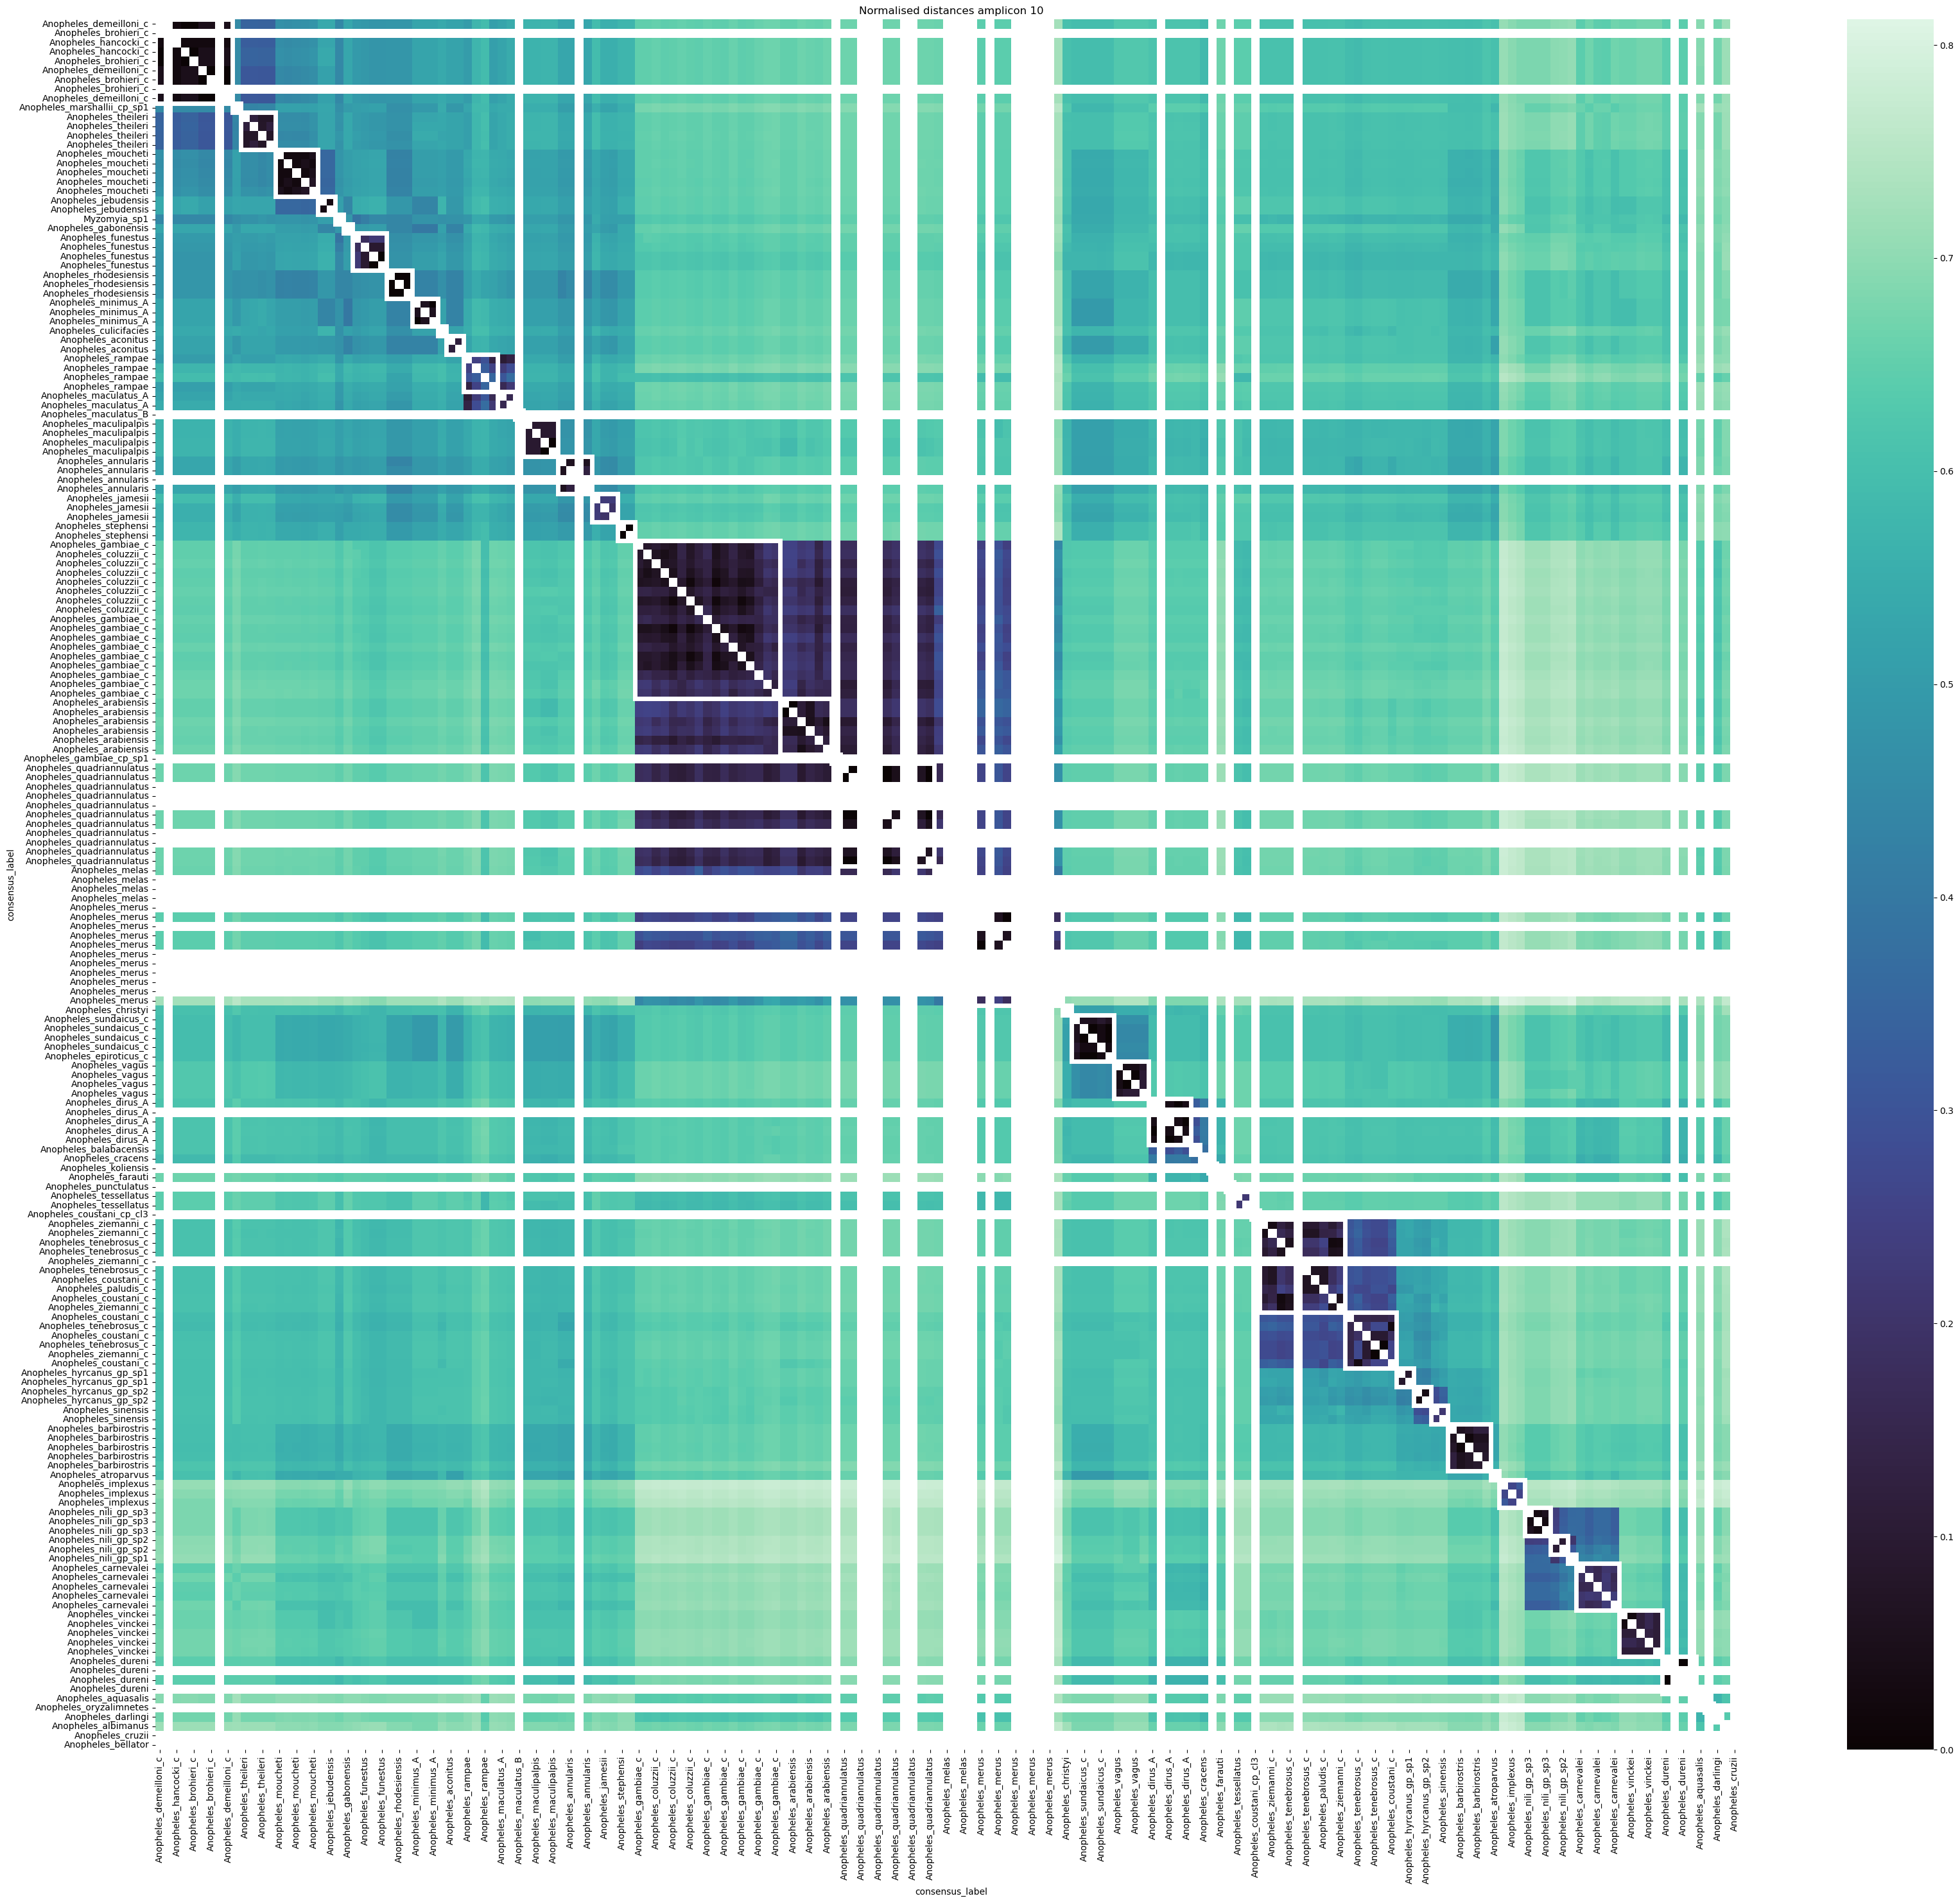

In [28]:
#show pairwise distances for a single target with fine-level species groups indicated
t=10
fig, ax = plt.subplots(figsize=(40,35))
df = pd.DataFrame(sample_distances[t,:,:], index=meta.loc[samples, 'consensus_label'], columns=meta.loc[samples, 'consensus_label'])
mask = np.isnan(sample_distances[t,:,:])
snsplot = seaborn.heatmap(df, ax=ax, mask=mask, cmap='mako').set_title(f'Normalised distances amplicon {t}')
x,y=0,0
for n in numfine:
    ax.add_patch( Rectangle((x,y),
                        n, n,
                        fc='none',
                        color ='white',
                        linewidth = 5) )
    x+=n
    y+=n
plt.show()

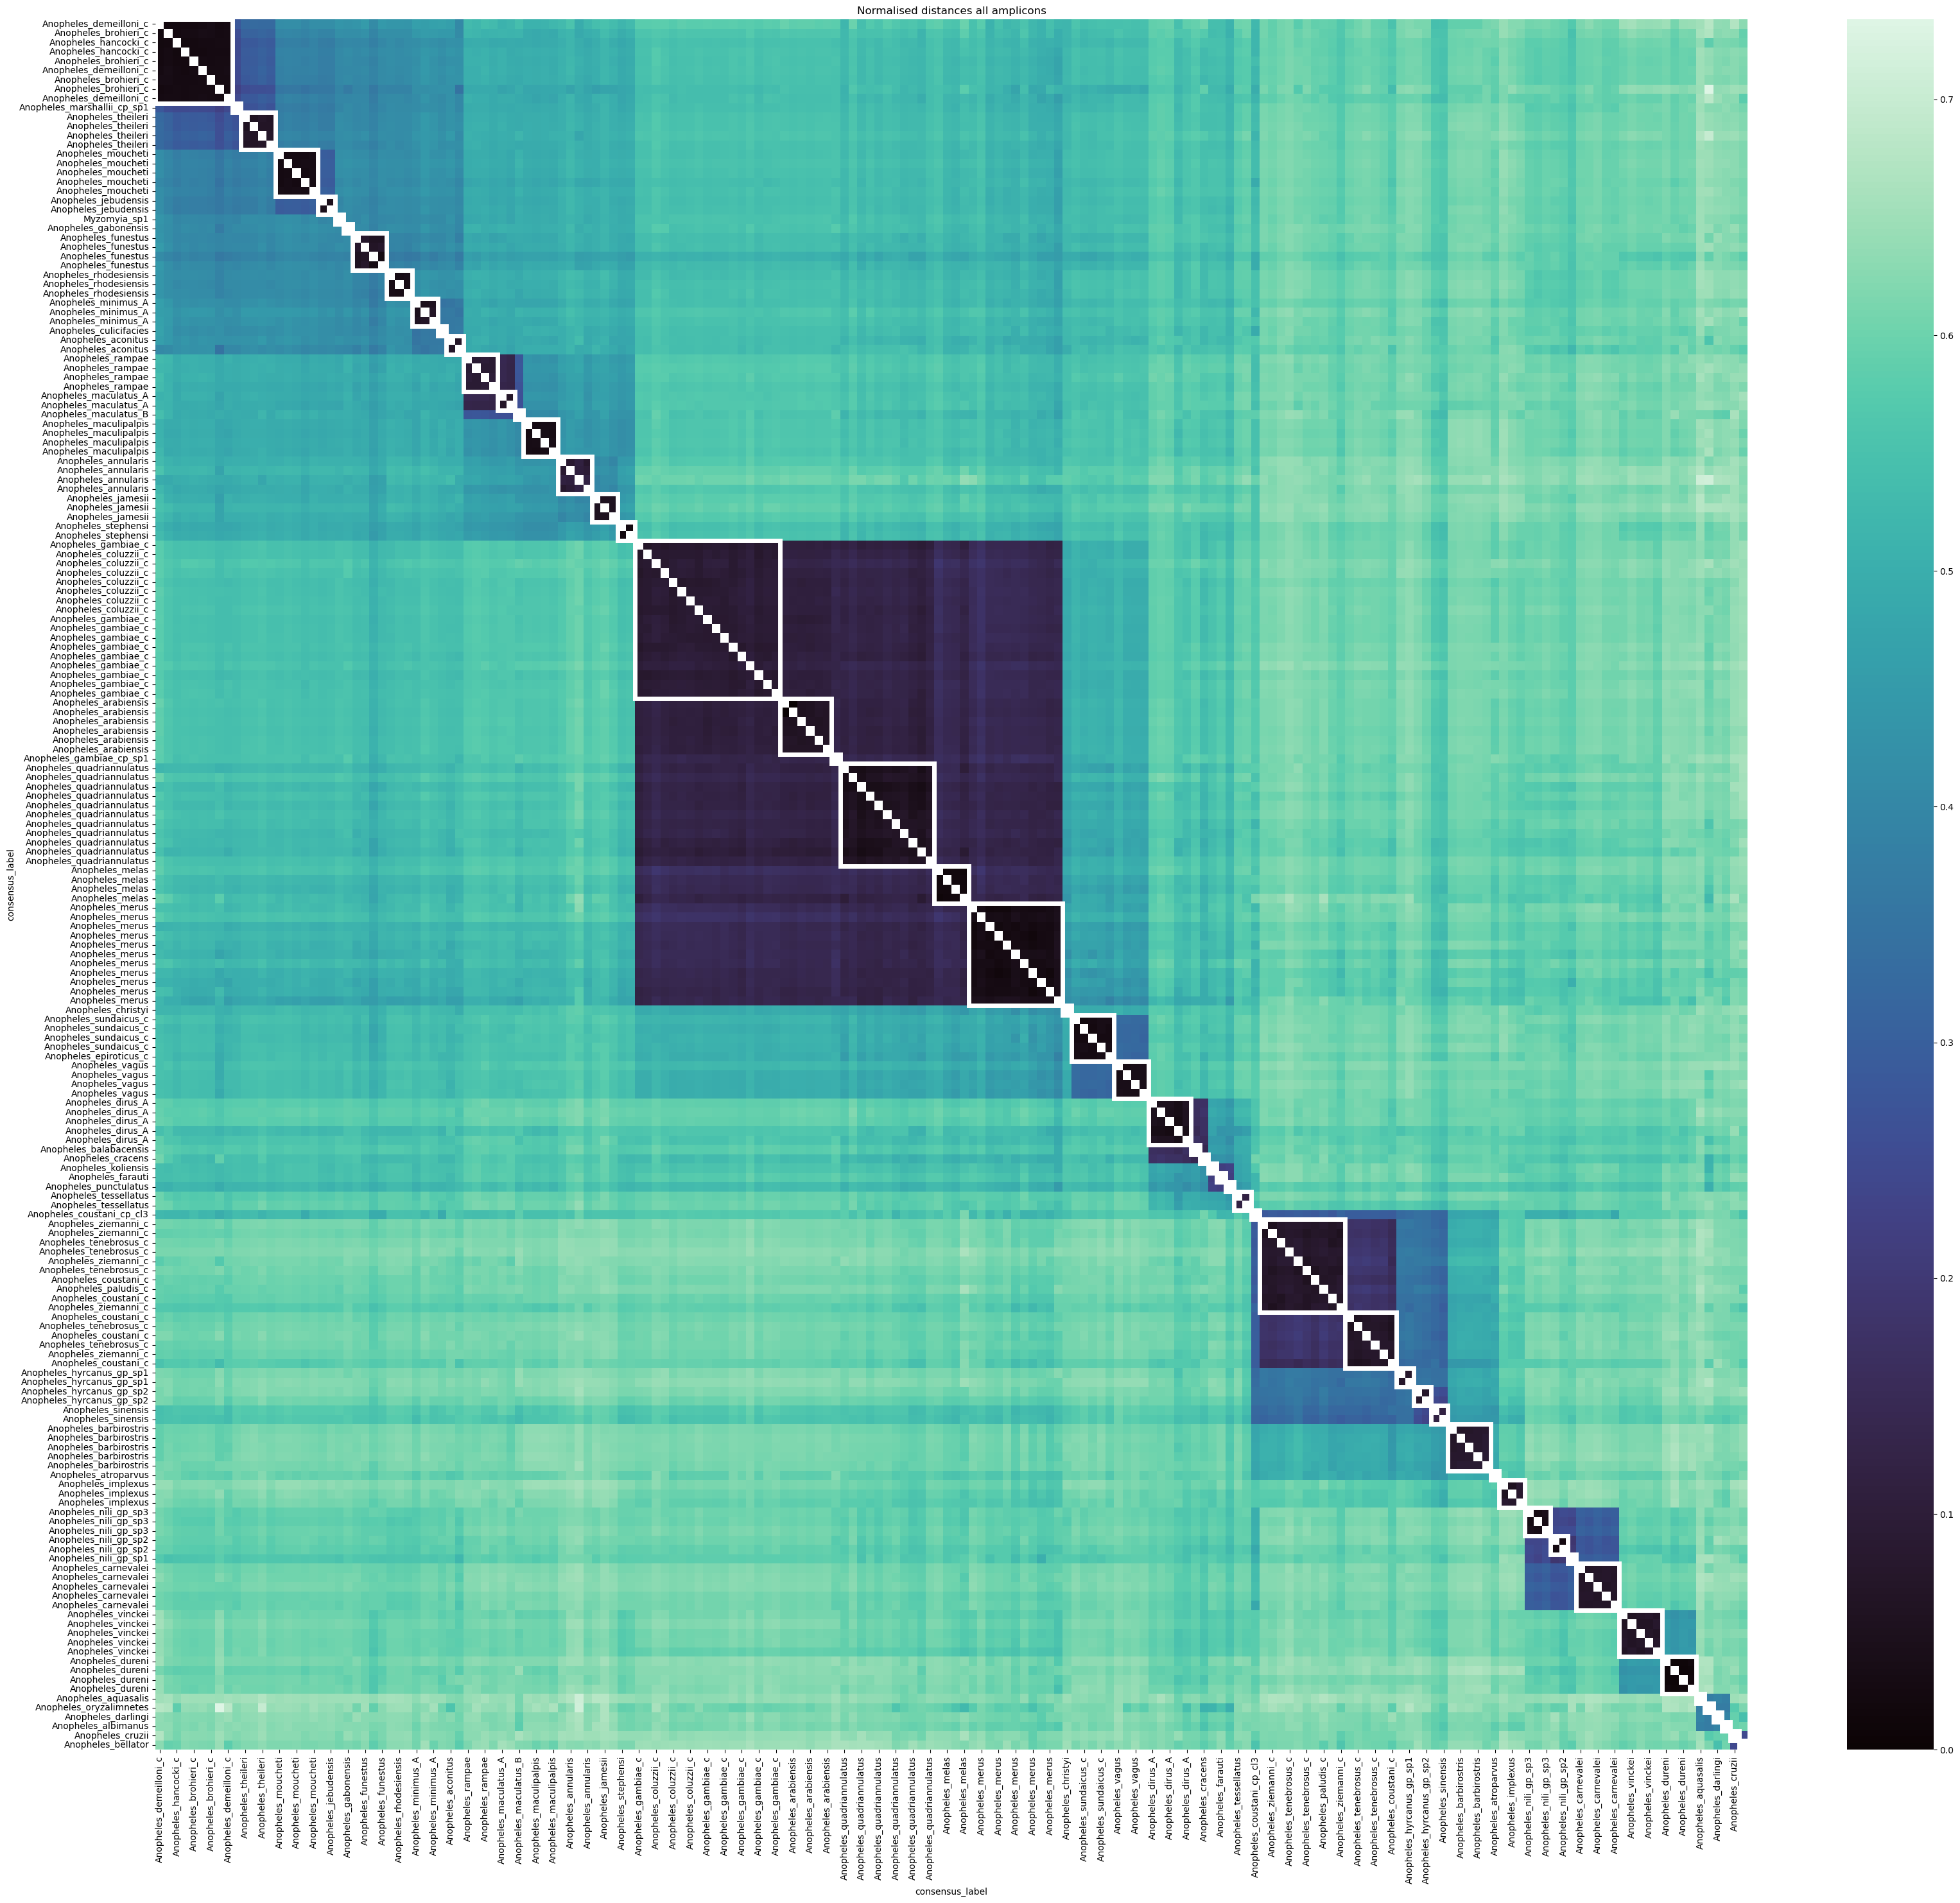

In [29]:
#show overall pairwise distances with fine-level species groups indicated
fig, ax = plt.subplots(figsize=(40,35))
norm = np.where((62-np.sum(np.isnan(sample_distances), axis=0))==0, -1, 62-np.sum(np.isnan(sample_distances), axis=0))
df = pd.DataFrame(np.nansum(sample_distances, axis=0)/norm, index=meta.loc[samples, 'consensus_label'], columns=meta.loc[samples, 'consensus_label'])
mask = np.all(np.isnan(sample_distances), axis=0)
snsplot = seaborn.heatmap(df, ax=ax, mask=mask, cmap='mako').set_title('Normalised distances all amplicons')
x,y=0,0
for n in numfine:
    ax.add_patch( Rectangle((x,y),
                        n, n,
                        fc='none',
                        color ='white',
                        linewidth = 5) )
    x+=n
    y+=n
plt.show()

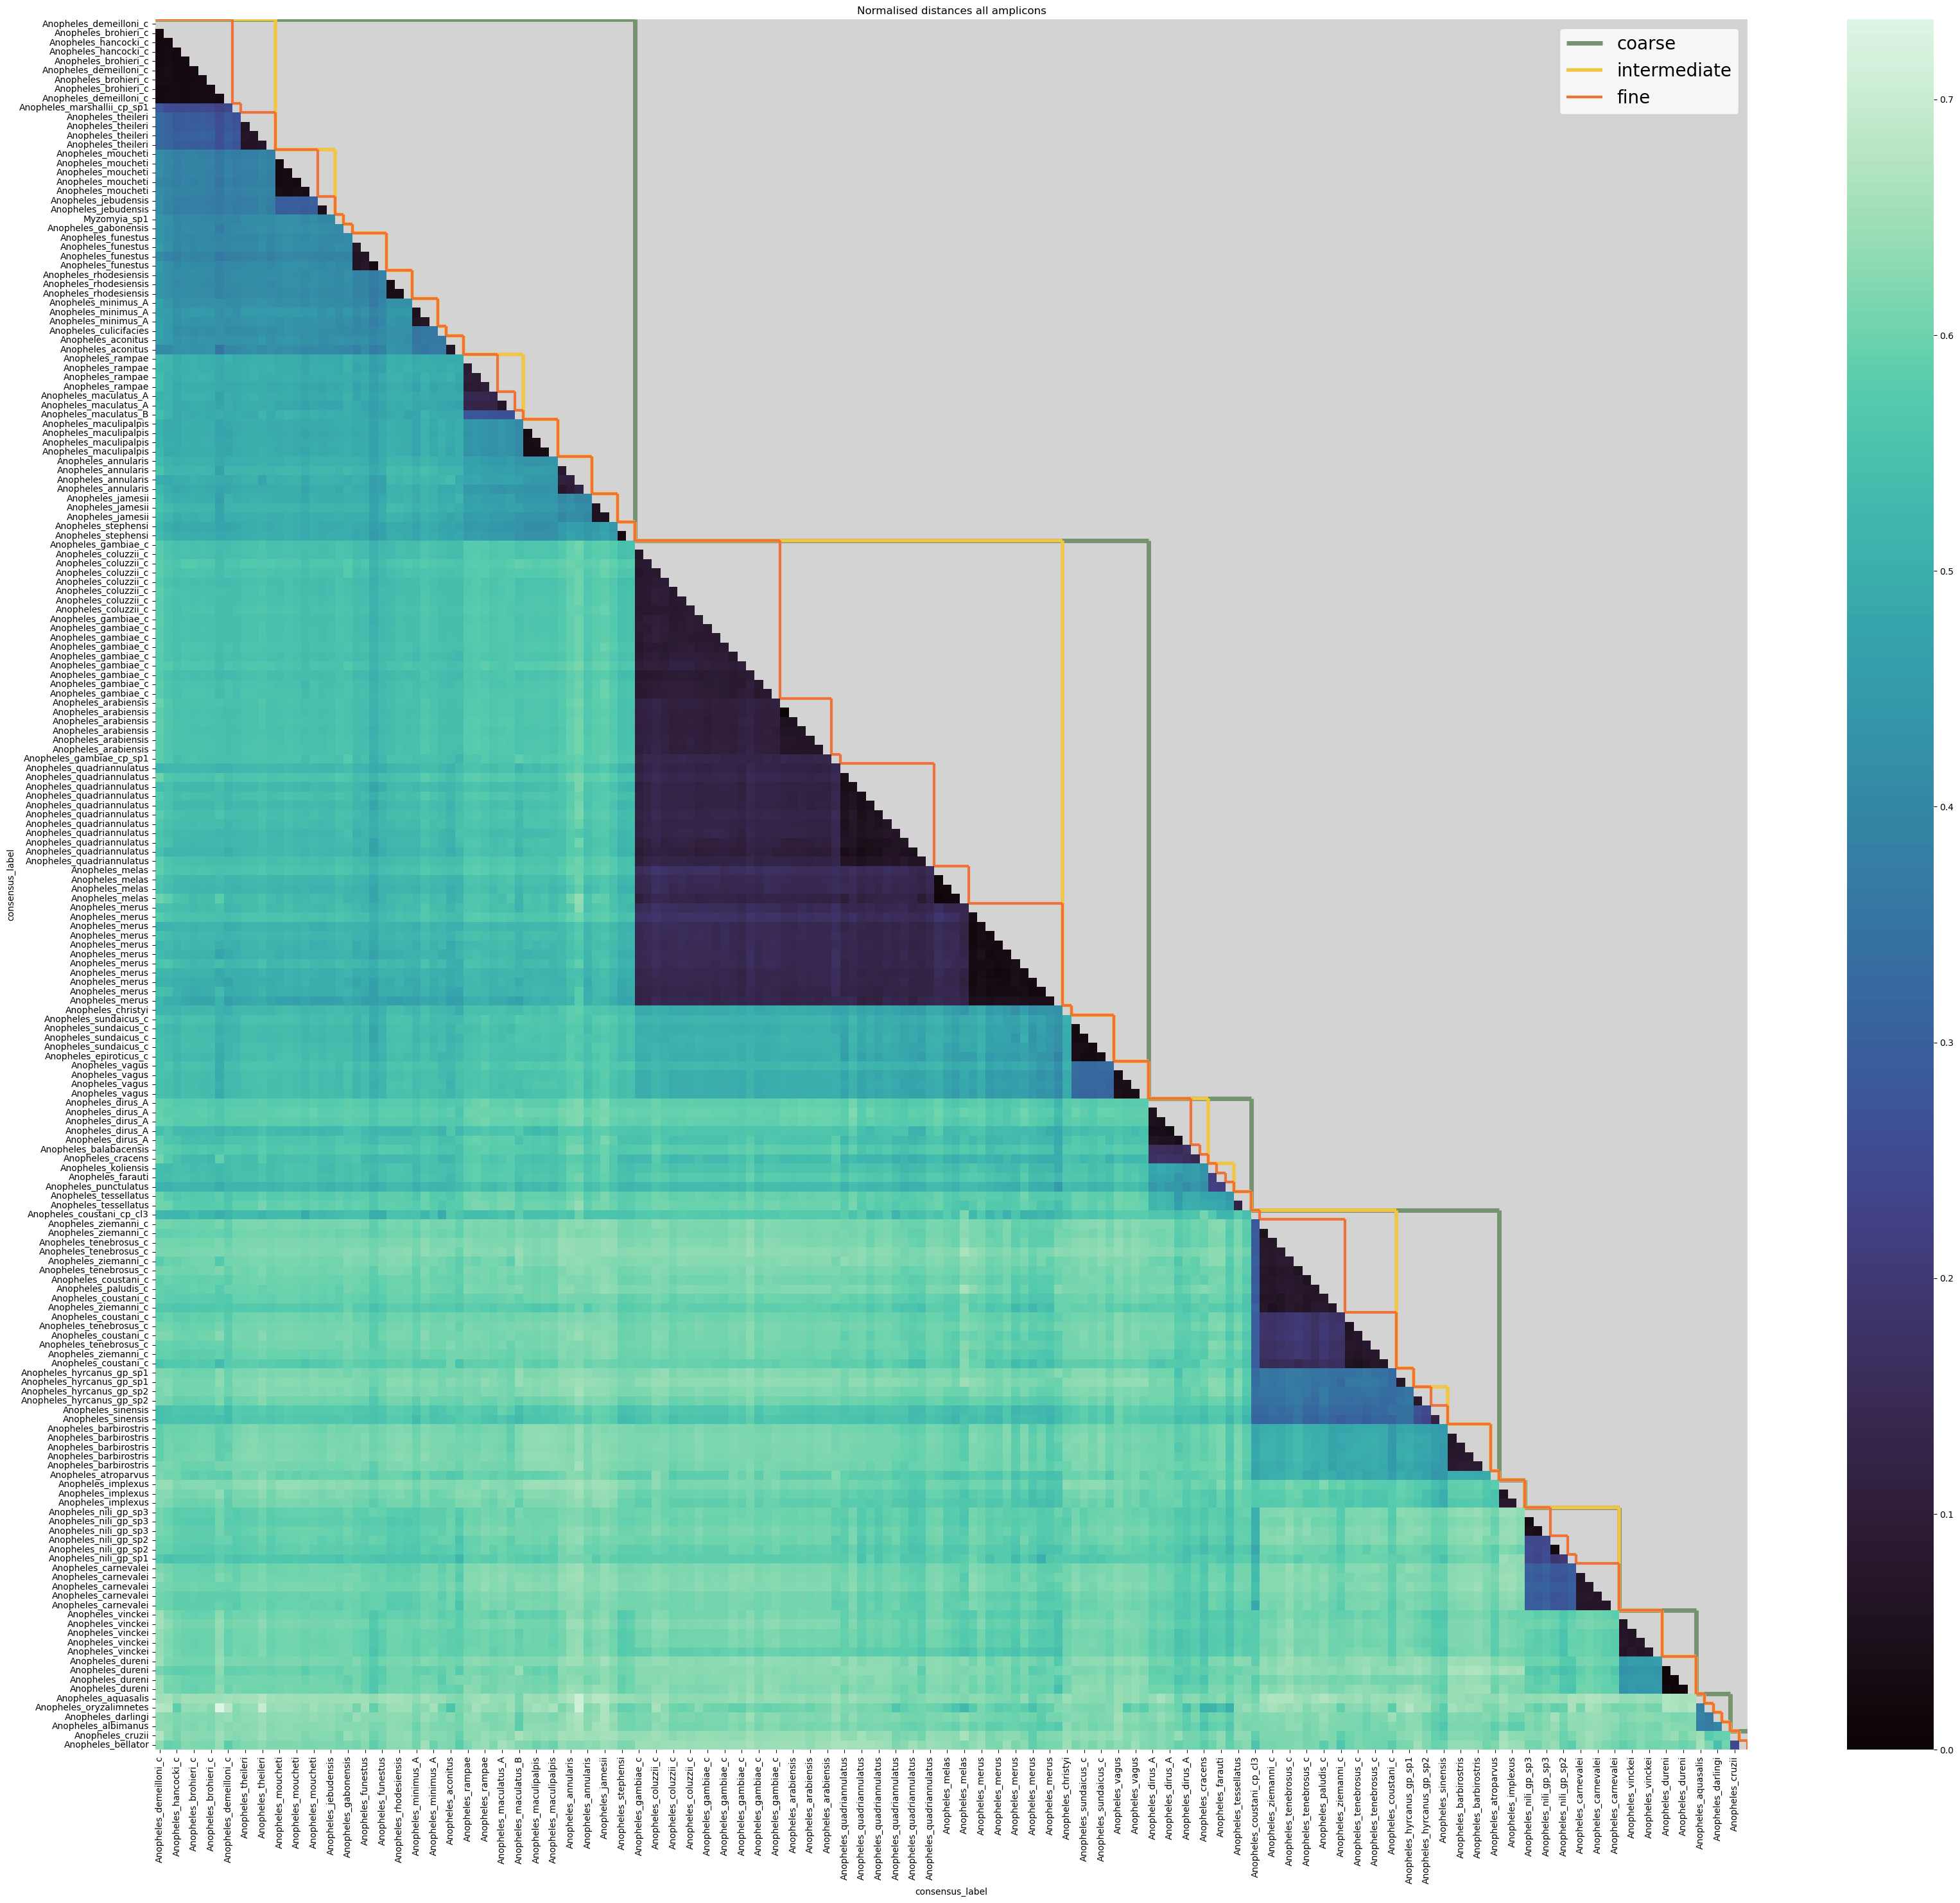

In [30]:
#show pairwise distances with fine, intermediate and coarse level species groups indicated
fig, ax = plt.subplots(figsize=(40,35))
norm = np.where((62-np.sum(np.isnan(sample_distances), axis=0))==0, -1, 62-np.sum(np.isnan(sample_distances), axis=0))
df = pd.DataFrame(np.nansum(sample_distances, axis=0)/norm, index=meta.loc[samples, 'consensus_label'], columns=meta.loc[samples, 'consensus_label'])
mask=np.triu(np.ones_like(df, dtype=bool))
snsplot = seaborn.heatmap(df, ax=ax, mask=mask, cmap='mako').set_title('Normalised distances all amplicons')

x,y=0,0
for n in numcoarse[:-1]:
    ax.vlines(x+n,y,y+n,color ="#769370", linewidth=5)
    ax.hlines(y,x,x+n,color ="#769370", linewidth=5)
    x+=n
    y+=n
ax.vlines(x+n,y,y+n,color ="#769370", linewidth=5)
ax.hlines(y,x,x+n,color ="#769370", linewidth=5, label='coarse')

x,y=0,0
for n in numint[:-1]:
    ax.vlines(x+n,y,y+n,color ="#F1C646", linewidth=4)
    ax.hlines(y,x,x+n,color ="#F1C646", linewidth=4)
    x+=n
    y+=n
ax.vlines(x+n,y,y+n,color ="#F1C646", linewidth=4)
ax.hlines(y,x,x+n,color ="#F1C646", linewidth=4, label='intermediate')

x,y=0,0
for n in numfine[:-1]:
    ax.vlines(x+n,y,y+n,color ="#F17236", linewidth=3)
    ax.hlines(y,x,x+n,color ="#F17236", linewidth=3)
    x+=n
    y+=n
ax.vlines(x+n,y,y+n,color ="#F17236", linewidth=3)
ax.hlines(y,x,x+n,color ="#F17236", linewidth=3, label='fine')
ax.legend(fontsize=20)
ax.patch.set_facecolor('lightgrey')
plt.show()

### Investigate distances

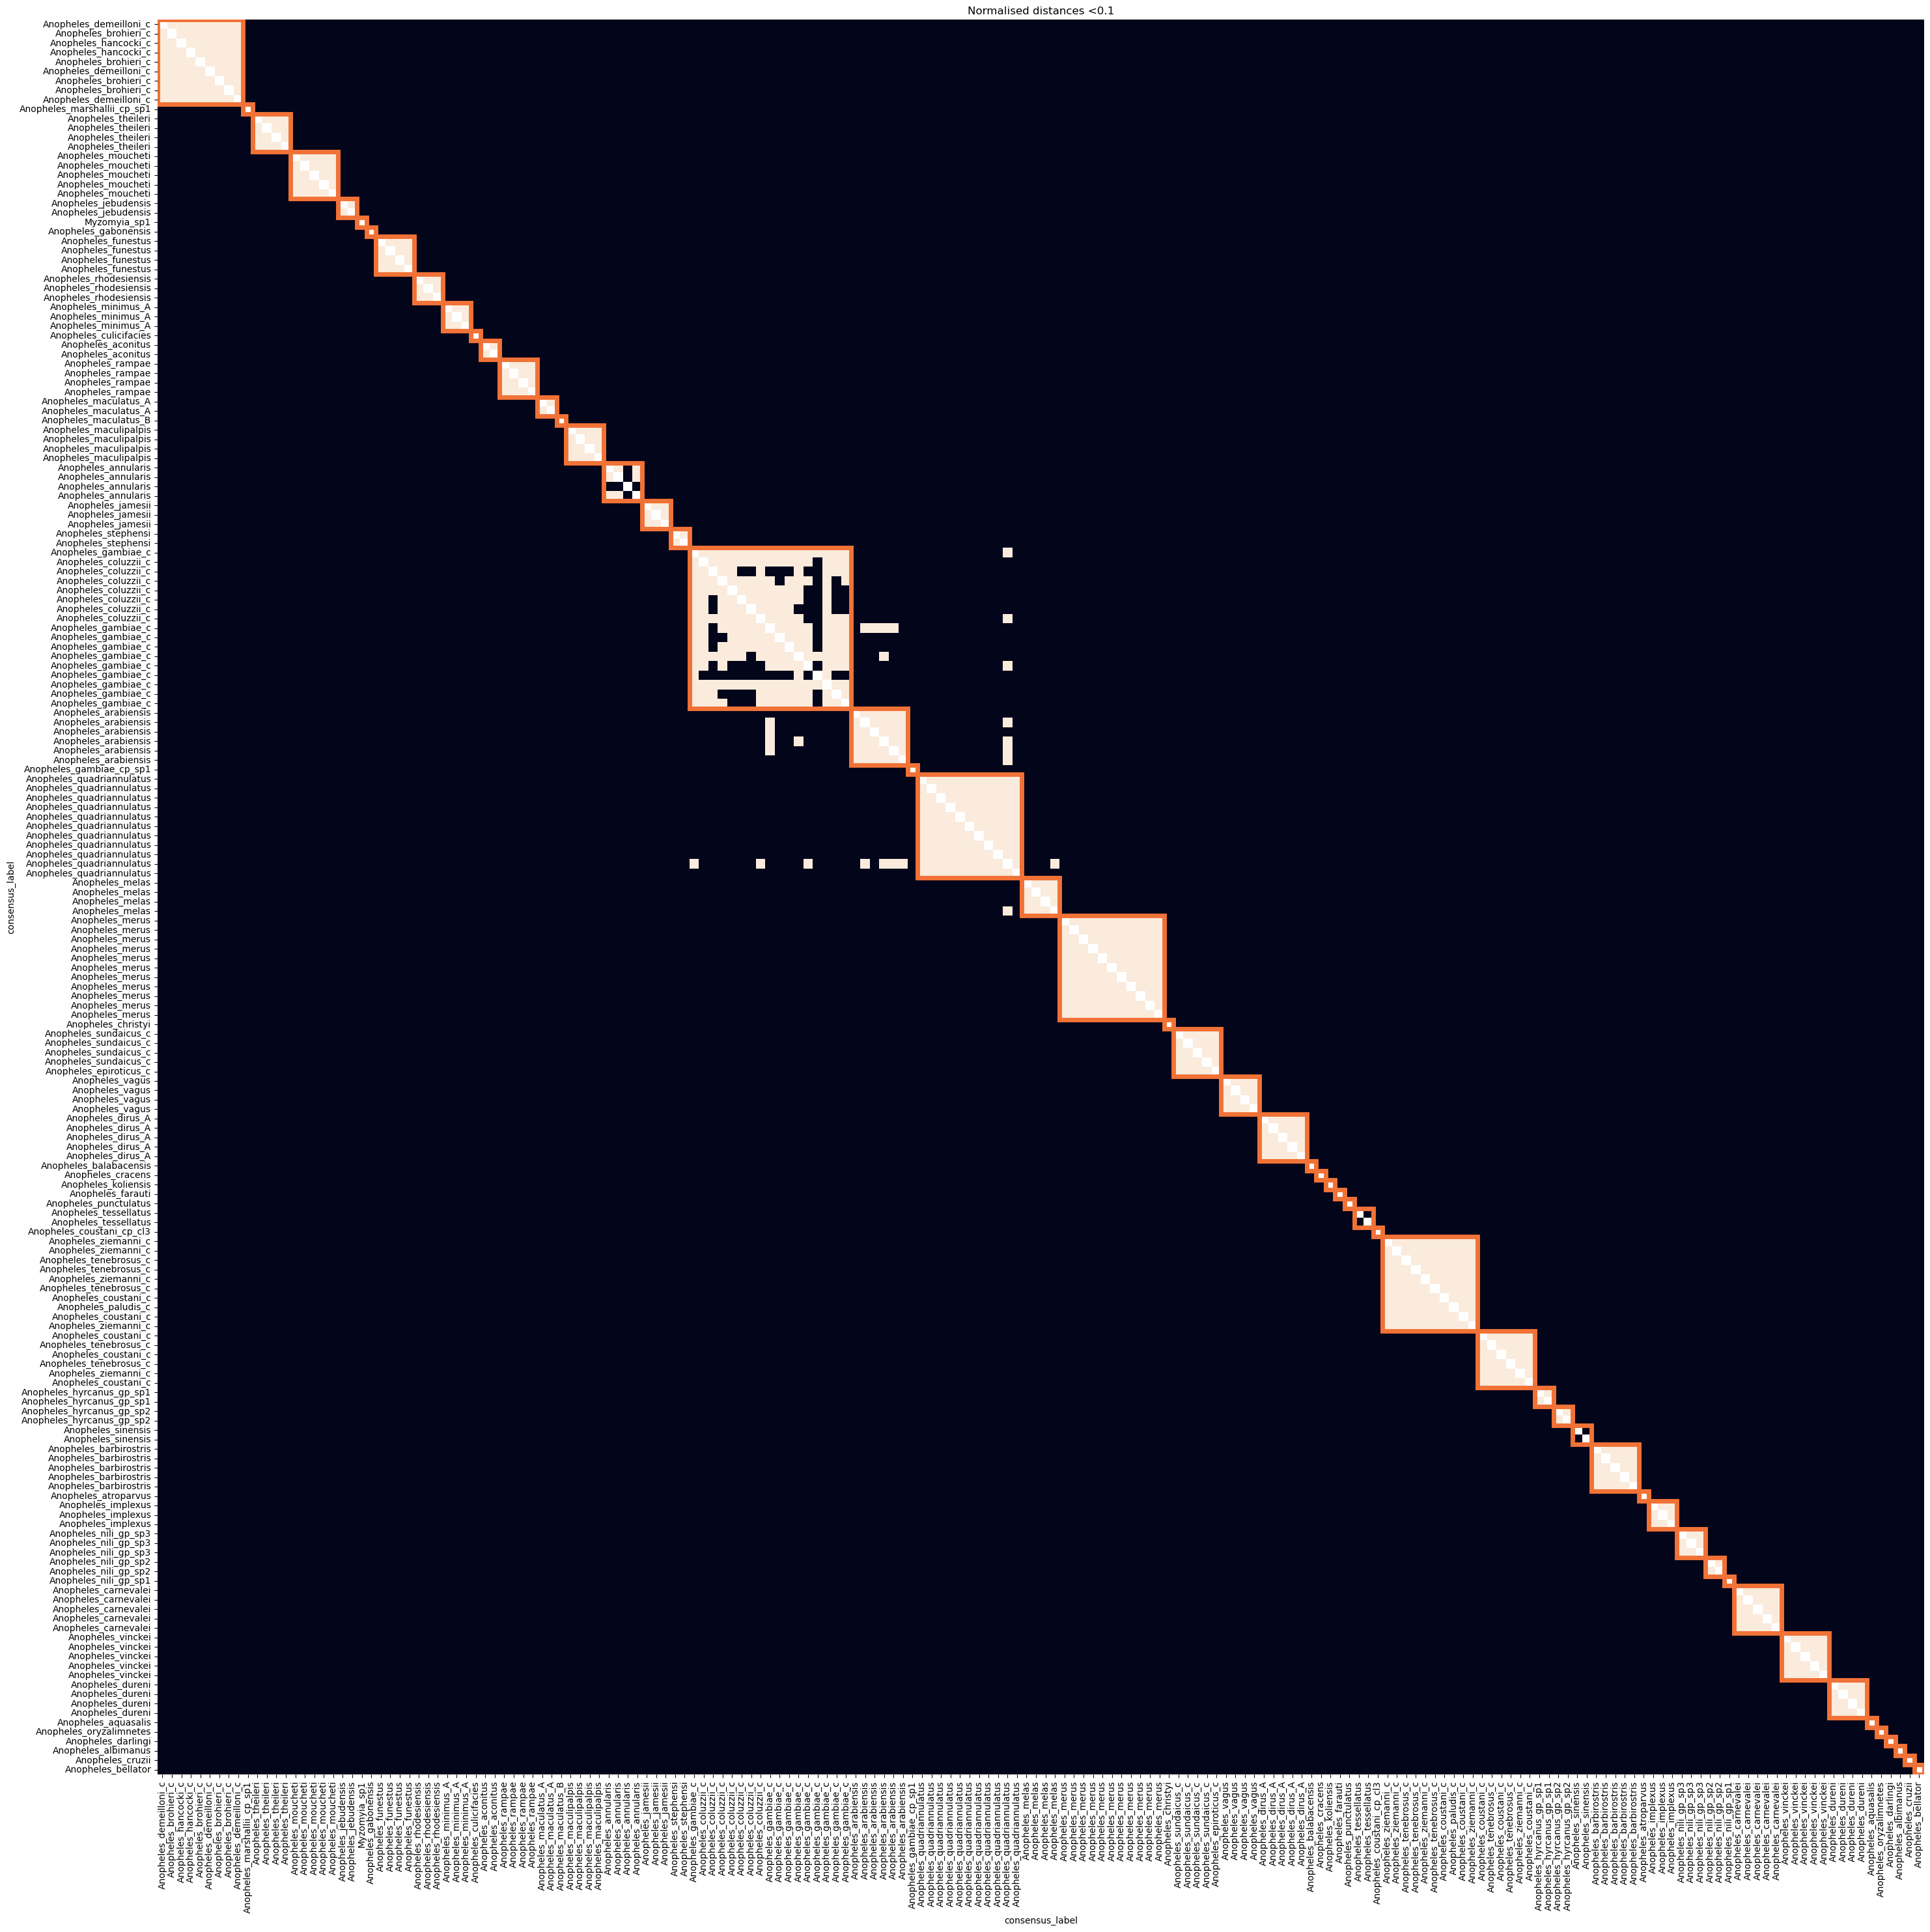

In [33]:
#for distance threshold 0.1, indicate which pairs have a distance smaller than the thresholds from each other
#good correspondance with species labels, except in some complexes
th=0.1
fig, ax = plt.subplots(figsize=(35,35))
mask = np.all(np.isnan(sample_distances), axis=0)
snsplot = seaborn.heatmap((df<th), ax=ax, mask=mask, cbar=False).set_title('Normalised distances <{}'.format(th))
x,y=0,0
for n in numfine:
    ax.add_patch( Rectangle((x,y),
                        n, n,
                        fc='none',
                        color ="#F17236",
                        linewidth = 5) )
    x+=n
    y+=n
plt.show()

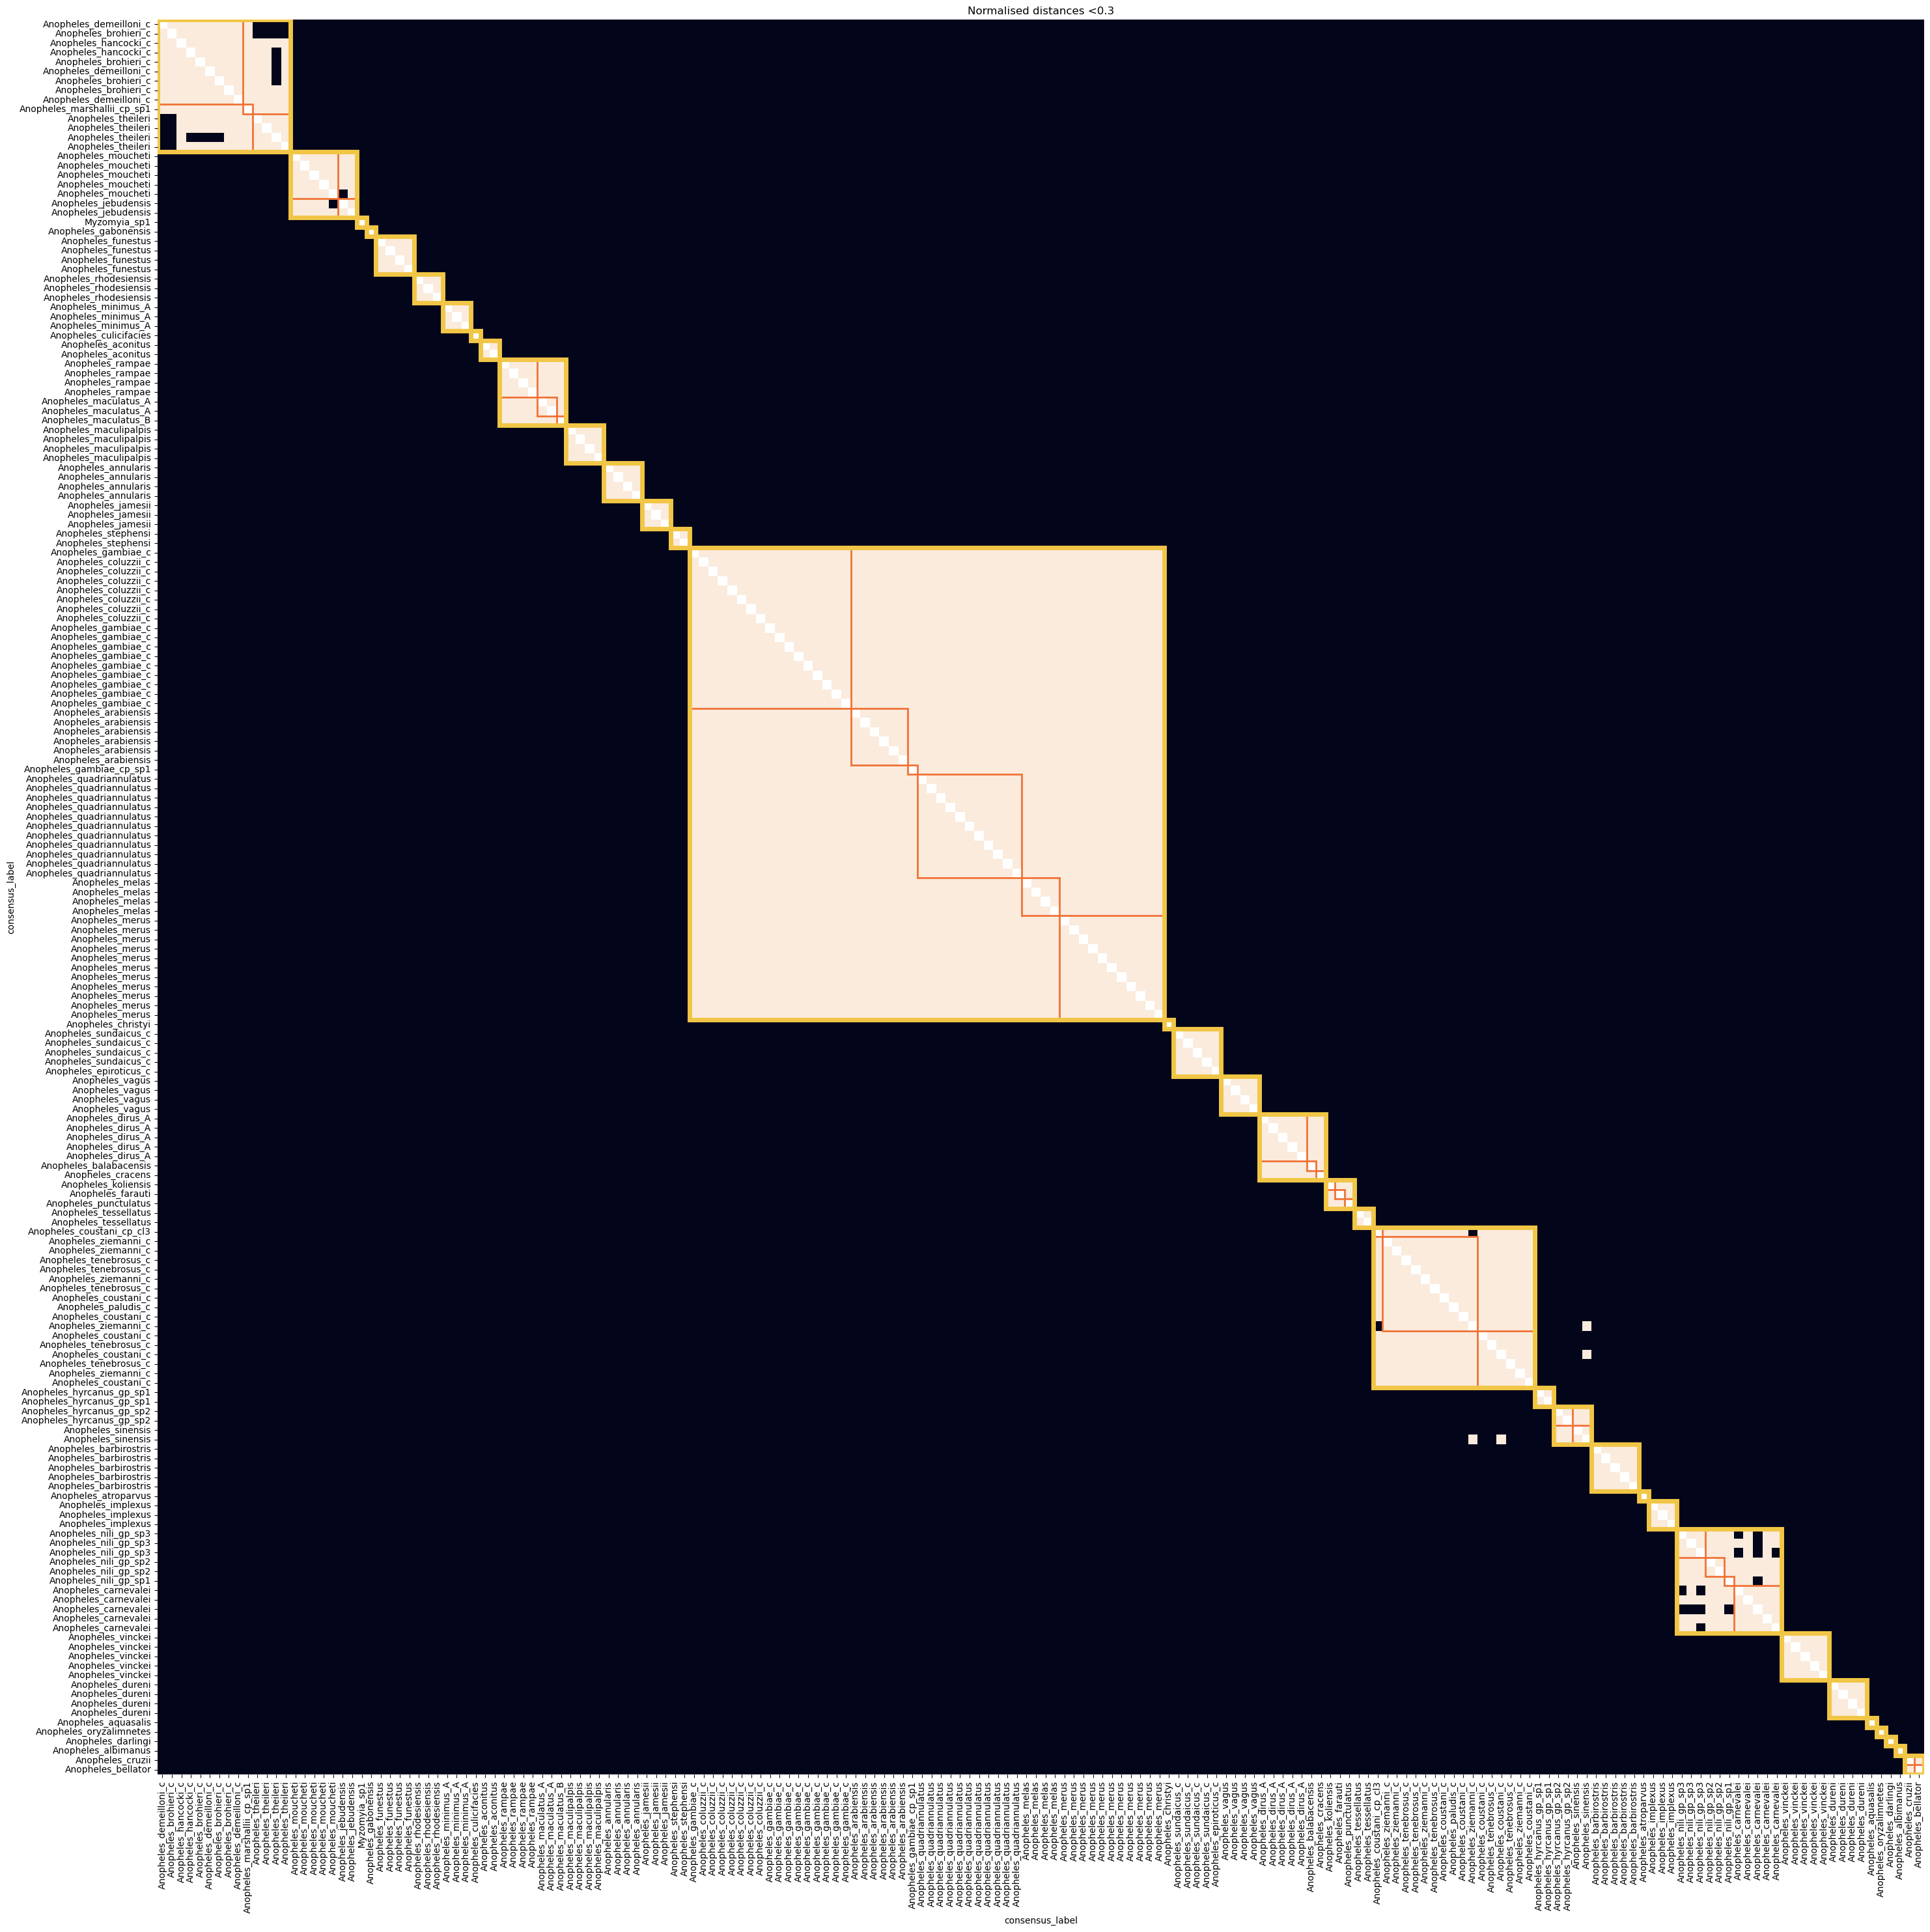

In [34]:
#for distance threshold 0.3, indicate which pairs have a distance smaller than the thresholds from each other
#the partitioning condition is very nearly satisfied and most single-sample-groups from fine level are now merged
th=0.3
fig, ax = plt.subplots(figsize=(35,35))
snsplot = seaborn.heatmap((df<th), ax=ax, mask=mask, cbar=False).set_title('Normalised distances <{}'.format(th))
x,y=0,0
for n in numfine:
    ax.add_patch( Rectangle((x,y),
                        n, n,
                        fc='none',
                        color ="#F17236",
                        linewidth = 2) )
    x+=n
    y+=n
x,y=0,0
for n in numint:
    ax.add_patch( Rectangle((x,y),
                        n, n,
                        fc='none',
                        color ="#F1C646",
                        linewidth = 5) )
    x+=n
    y+=n
plt.show()

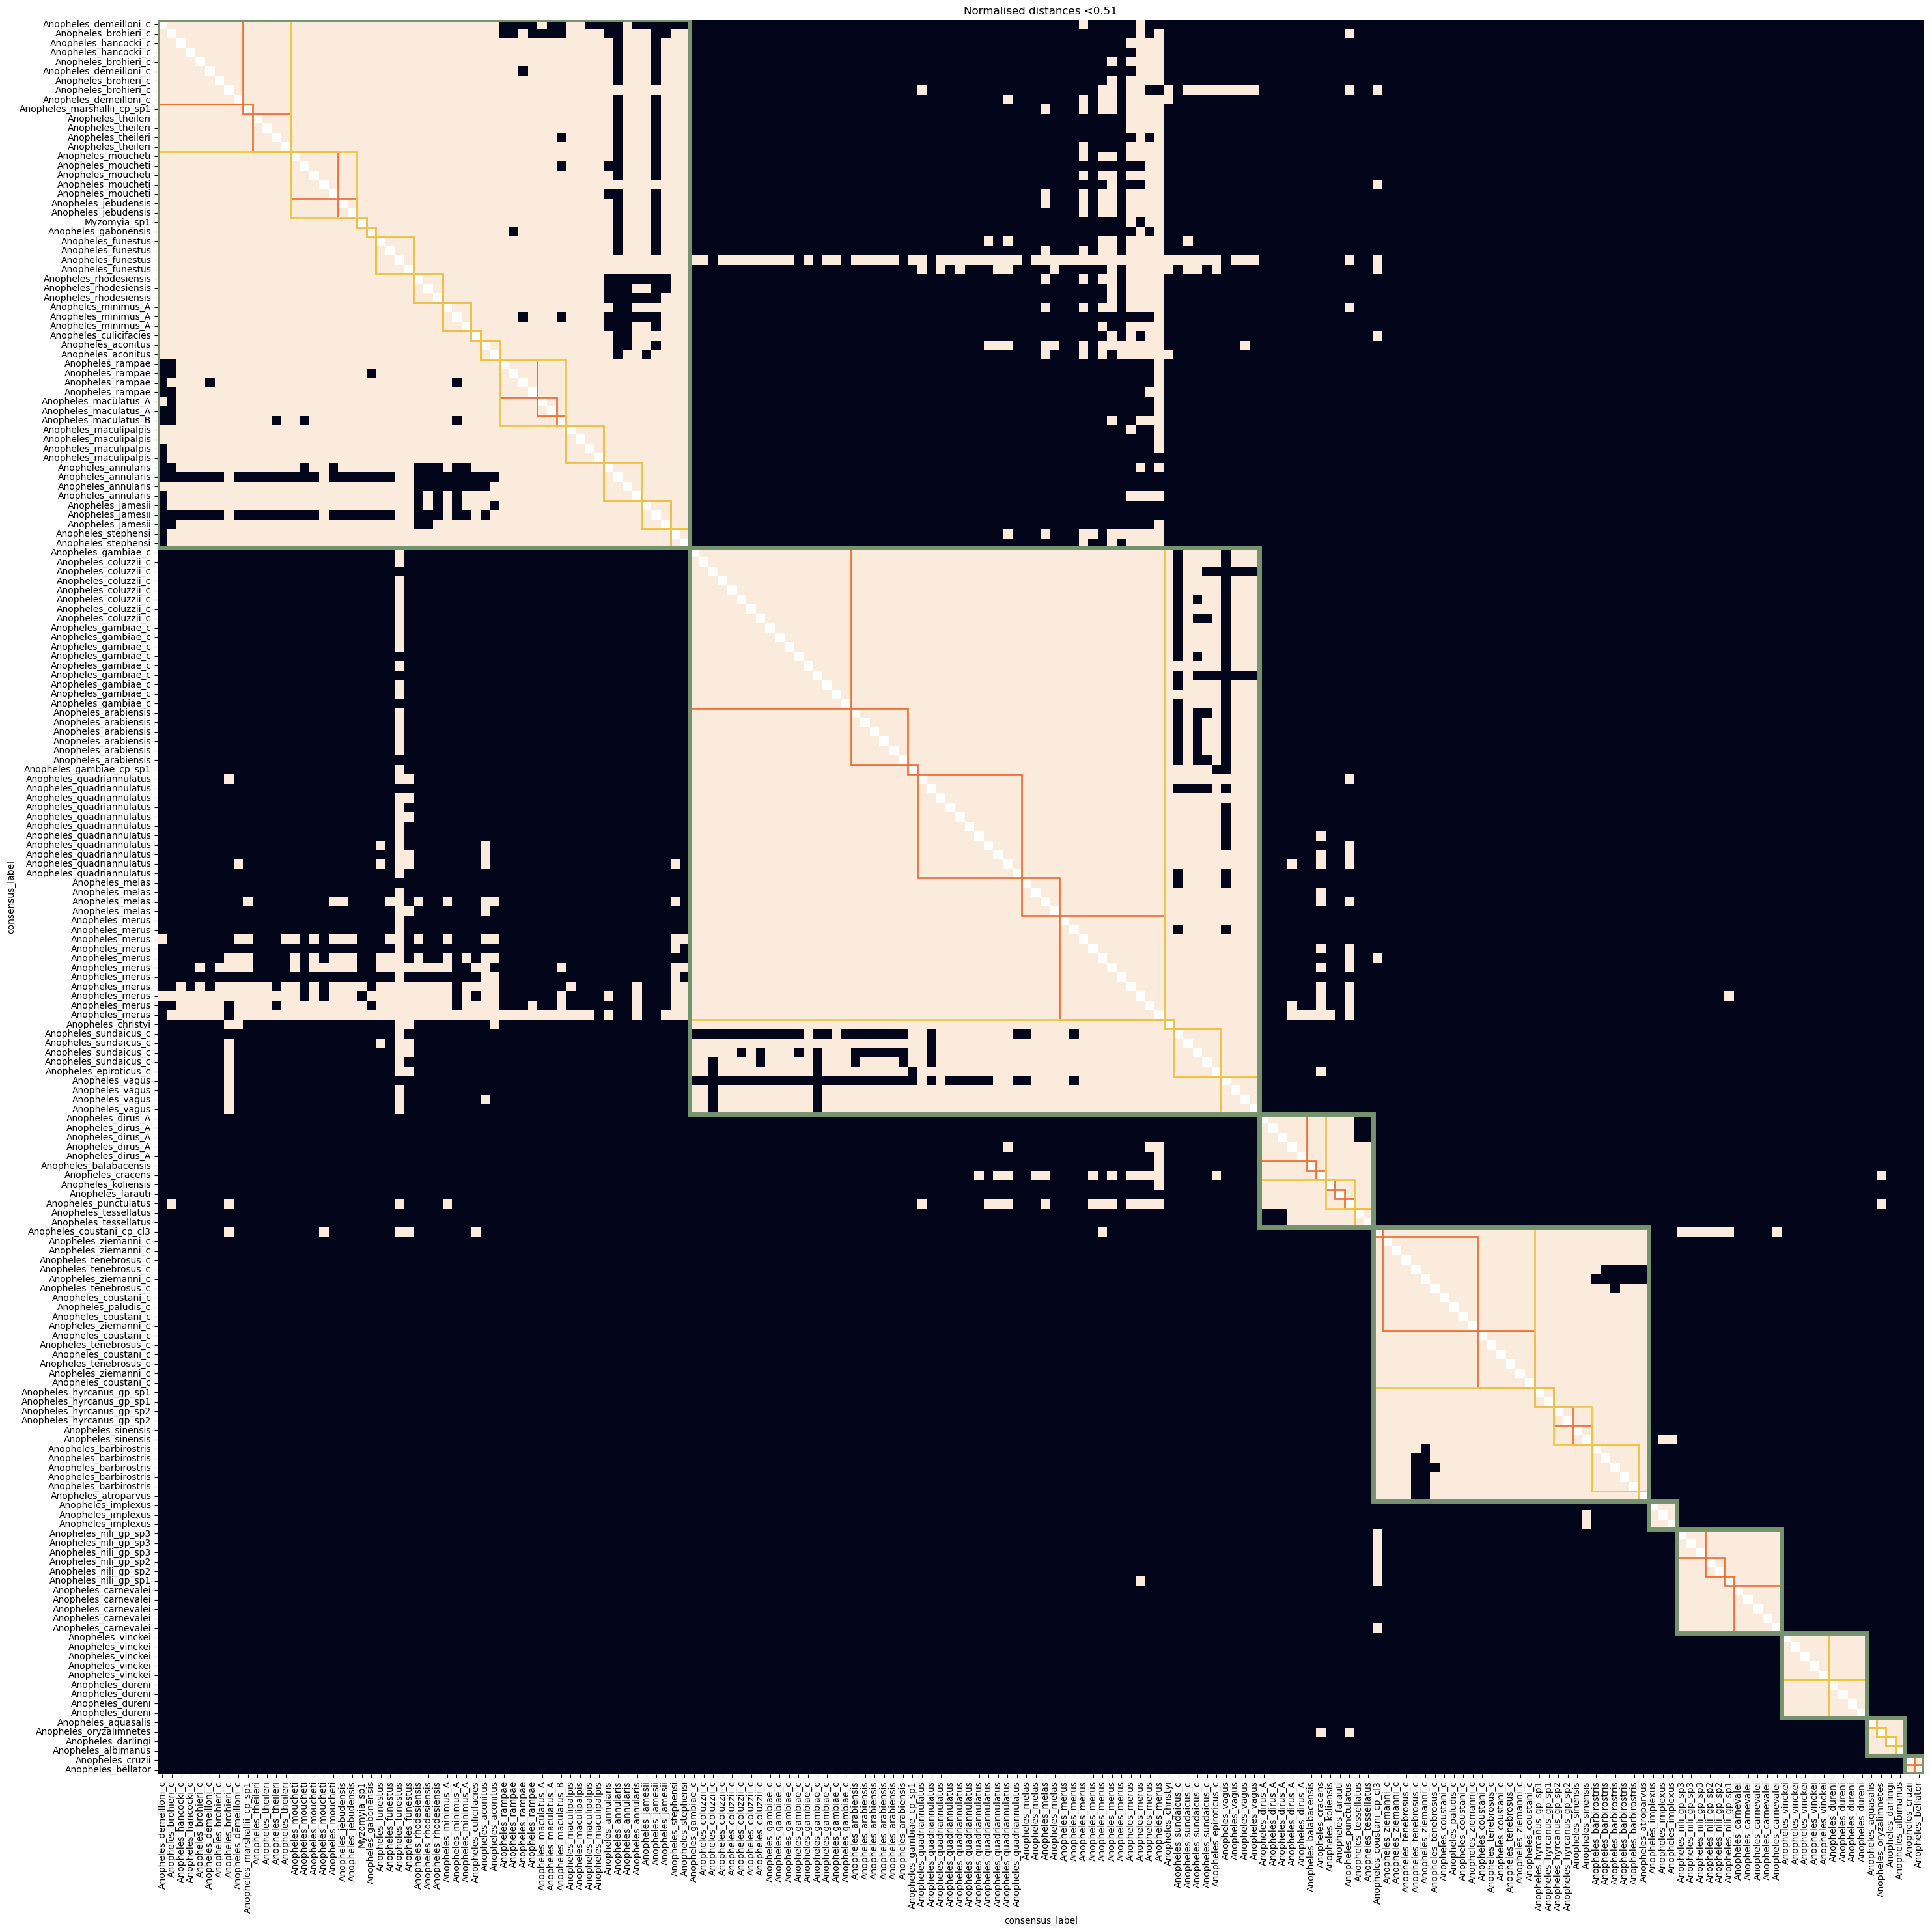

In [35]:
#for distance threshold 0.51, indicate which pairs have a distance smaller than the thresholds from each other
#paritioning condition more violated than before, but reasonably good correspondence to series level taxonomy
th=0.51
fig, ax = plt.subplots(figsize=(35,35))
snsplot = seaborn.heatmap((df<th), ax=ax, mask=mask, cbar=False).set_title('Normalised distances <{}'.format(th))
x,y=0,0
for n in numfine:
    ax.add_patch( Rectangle((x,y),
                        n, n,
                        fc='none',
                        color ="#F17236",
                        linewidth = 2) )
    x+=n
    y+=n
x,y=0,0
for n in numint:
    ax.add_patch( Rectangle((x,y),
                        n, n,
                        fc='none',
                        color ="#F1C646",
                        linewidth = 2) )
    x+=n
    y+=n
x,y=0,0
for n in numcoarse:
    ax.add_patch( Rectangle((x,y),
                        n, n,
                        fc='none',
                        color ="#769370",
                        linewidth = 5) )
    x+=n
    y+=n
plt.show()